In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import os

# Ensure correct folder exists
os.makedirs("../models", exist_ok=True)

In [84]:
# Dataset loading in
df = pd.read_csv('../data/dataset.csv')
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
# Checking column names
df.columns
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB


,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
count,4920,4920,4920,4920,4572,3714,2934,2268,1944,1692,1512,1194,744,504,306,240,192,72
unique,41,34,48,54,50,38,32,26,21,22,21,18,11,8,4,3,3,1
top,Fungal infection,vomiting,vomiting,fatigue,high_fever,headache,nausea,abdominal_pain,abdominal_pain,yellowing_of_eyes,yellowing_of_eyes,irritability,malaise,muscle_pain,chest_pain,chest_pain,blood_in_sputum,muscle_pain
freq,120,822,870,726,378,348,390,264,276,228,198,120,126,72,96,144,72,72


In [86]:
# Cleaning the nulls
df = df.dropna()

# Text Cleaning & Preprocessing

In [87]:
# Cleaning Text Function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [88]:
# Load the symptom description file
desc_df = pd.read_csv('../data/symptom_description.csv')
desc_df.head()

,Disease,Description
0,Drug Reaction,An adverse drug reaction (ADR) is an injury ca...
1,Malaria,An infectious disease caused by protozoan para...
2,Allergy,An allergy is an immune system response to a f...
3,Hypothyroidism,"Hypothyroidism, also called underactive thyroi..."
4,Psoriasis,Psoriasis is a common skin disorder that forms...


In [89]:
desc_df.columns

Index(['Disease', 'Description'], dtype='object')

In [90]:
# Clean The Description
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply to description
desc_df['clean_text'] = desc_df['Description'].apply(clean_text)
desc_df[['Disease', 'clean_text']].head()

,Disease,clean_text
0,Drug Reaction,an adverse drug reaction adr is an injury caus...
1,Malaria,an infectious disease caused by protozoan para...
2,Allergy,an allergy is an immune system response to a f...
3,Hypothyroidism,hypothyroidism also called underactive thyroid...
4,Psoriasis,psoriasis is a common skin disorder that forms...


In [91]:
desc_df.isnull().sum()
desc_df = desc_df.dropna()

In [92]:
symptom_df = pd.read_csv('../data/dataset.csv')
merged_df = pd.merge(symptom_df, desc_df, on='Disease', how='inner')

# TF-IDF

In [93]:
X = desc_df['clean_text']
y = desc_df['Disease']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combining datsets

In [94]:
# Load main dataset
df = pd.read_csv('../data/dataset.csv')

# Combine all symptoms into one string per row
symptom_cols = [col for col in df.columns if 'Symptom_' in col]
df['combined_symptoms'] = df[symptom_cols].fillna('').apply(lambda x: ' '.join(x), axis=1)

In [95]:
# Clean combined text
df['clean_text'] = df['combined_symptoms'].apply(clean_text)

In [96]:
# Prepare target
X = df['clean_text']
y = df['Disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
# Vectorize and classify (TF-IDF + LogisticRegression)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [98]:
import joblib
import os

# Make sure output folder exists
os.makedirs("notebooks/outputs/models", exist_ok=True)

# Save the model
joblib.dump(model, 'notebooks/outputs/models/disease_model.joblib')

# Save the vectorizer
joblib.dump(vectorizer, 'notebooks/outputs/models/vectorizer.joblib')
print("✅ Model and vectorizer saved successfully.")

✅ Model and vectorizer saved successfully.


In [99]:
import os
print(os.listdir("notebooks/outputs/models"))

['disease_model.joblib', 'vectorizer.joblib']


# Using the symptom severity as weighted inputs

In [100]:
severity_df = pd.read_csv('../data/symptom-severity.csv')

# Clean column names
severity_df.columns = [col.strip().lower() for col in severity_df.columns]
severity_map = dict(zip(severity_df['symptom'], severity_df['weight']))

def score_symptoms(row):
    symptoms = row['combined_symptoms'].split()
    return sum(severity_map.get(symptom.strip().lower(), 0) for symptom in symptoms)

df['symptom_severity_score'] = df.apply(score_symptoms, axis=1)

# Add Precautions Post-Prediction

In [101]:
precautions_df = pd.read_csv('../data/symptom_precaution.csv')
precautions_map = precautions_df.set_index('Disease').T.to_dict('list')

def get_precautions(disease):
    return precautions_map.get(disease, ["N/A"])

# Example:
input_text = "headache fatigue"
input_vec = vectorizer.transform([input_text])  # keep as 2D sparse matrix
predicted_disease = model.predict(input_vec)[0]
print("Predicted Disease:", predicted_disease)
print("Precautions:", get_precautions(predicted_disease))

Predicted Disease: Paralysis (brain hemorrhage)
Precautions: ['massage', 'eat healthy', 'exercise', 'consult doctor']


/var/folders/1w/lrpq1gv15cn10njb1pv9_pd00000gn/T/ipykernel_7186/1876056982.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=symptom_freq_df.head(20), x='Count', y='Symptom', palette='viridis')


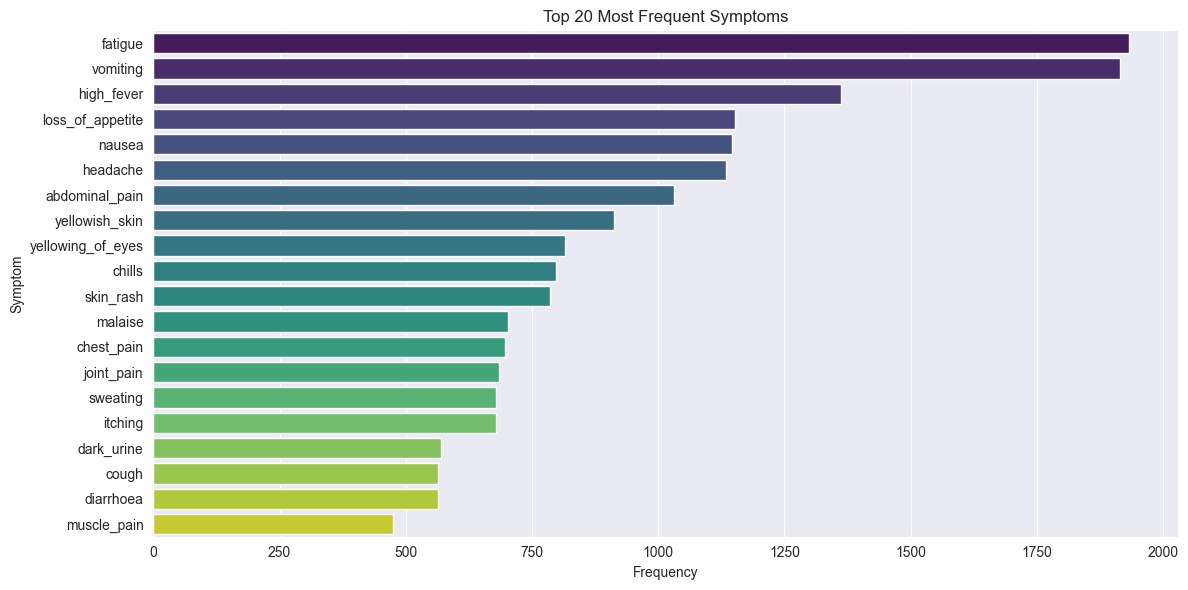

In [102]:
from collections import Counter

# Flatten all symptoms into one big list
all_symptoms = df['combined_symptoms'].str.split().sum()
symptom_counts = Counter(all_symptoms)

# Convert to DataFrame for plotting
symptom_freq_df = pd.DataFrame(symptom_counts.items(), columns=['Symptom', 'Count']).sort_values(by='Count', ascending=False)

# Plot top 20 symptoms
plt.figure(figsize=(12, 6))
sns.barplot(data=symptom_freq_df.head(20), x='Count', y='Symptom', palette='viridis')
plt.title('Top 20 Most Frequent Symptoms')
plt.xlabel('Frequency')
plt.ylabel('Symptom')
plt.tight_layout()
plt.show()

# TOP TF-IDF words by disease

In [103]:
# Get class labels and feature names
classes = model.classes_
feature_names = vectorizer.get_feature_names_out()

def top_tfidf_words(class_index, top_n=10):
    class_coef = model.coef_[class_index]
    top_indices = class_coef.argsort()[::-1][:top_n]
    return [(feature_names[i], class_coef[i]) for i in top_indices]

# Display for first 5 diseases
for i, disease in enumerate(classes[:5]):
    print(f"Top words for '{disease}':")
    for word, weight in top_tfidf_words(i):
        print(f"  {word} ({weight:.3f})")
    print("-" * 40)

Top words for '(vertigo) Paroymsal  Positional Vertigo':
  unsteadiness (3.965)
  spinning_movements (3.452)
  loss_of_balance (2.791)
  nausea (1.669)
  headache (1.523)
  vomiting (0.997)
  yellow_urine (-0.039)
  puffy_face_and_eyes (-0.040)
  blood_in_sputum (-0.040)
  cold_hands_and_feets (-0.040)
----------------------------------------
Top words for 'AIDS':
  muscle_wasting (3.459)
  extra_marital_contacts (3.459)
  patches_in_throat (3.459)
  high_fever (1.438)
  yellow_urine (-0.050)
  drying_and_tingling_lips (-0.051)
  anxiety (-0.051)
  puffy_face_and_eyes (-0.052)
  weight_gain (-0.052)
  cold_hands_and_feets (-0.052)
----------------------------------------
Top words for 'Acne':
  blackheads (3.488)
  scurring (3.437)
  pus_filled_pimples (3.437)
  skin_rash (1.902)
  throat_irritation (-0.044)
  runny_nose (-0.044)
  sinus_pressure (-0.044)
  congestion (-0.044)
  loss_of_smell (-0.044)
  redness_of_eyes (-0.044)
----------------------------------------
Top words for 'Al

# Confusion Matrix And Classification Report

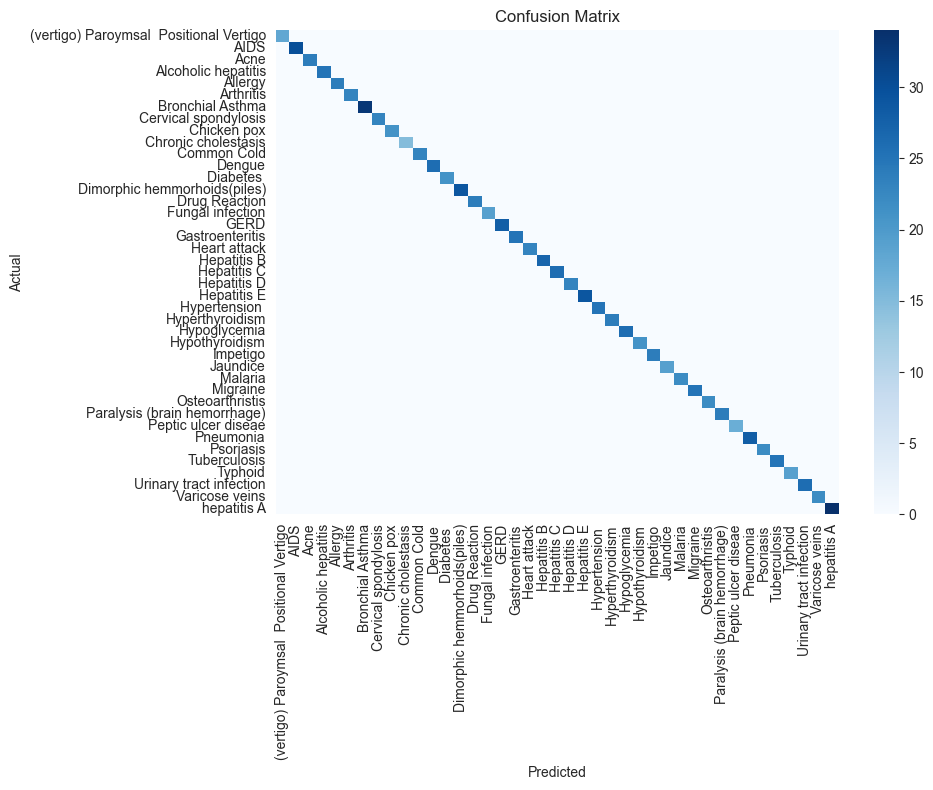

Classification Report:

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        18
                                   AIDS       1.00      1.00      1.00        30
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        23
                       Bronchial Asthma       1.00      1.00      1.00        33
                   Cervical spondylosis       1.00      1.00      1.00        23
                            Chicken pox       1.00      1.00      1.00        21
                    Chronic cholestasis       1.00      1.00      1.00        15
                            Common Cold       1.00      1.00      1.00        23
   

In [104]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test_tfidf)

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

In [105]:
# Wrap prediction into a function for easier use later in app
def predict_disease(symptom_text):
    clean_input = clean_text(symptom_text)
    input_vec = vectorizer.transform([clean_input])
    prediction = model.predict(input_vec)[0]
    precautions = get_precautions(prediction)

    print(f"Predicted Disease: {prediction}")
    print("Recommended Precautions:")
    for p in precautions:
        print(f" - {p}")

Extracted Entities: []


/var/folders/1w/lrpq1gv15cn10njb1pv9_pd00000gn/T/ipykernel_7186/2297936642.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_impact, x='Impact', y='symptom', palette='magma')


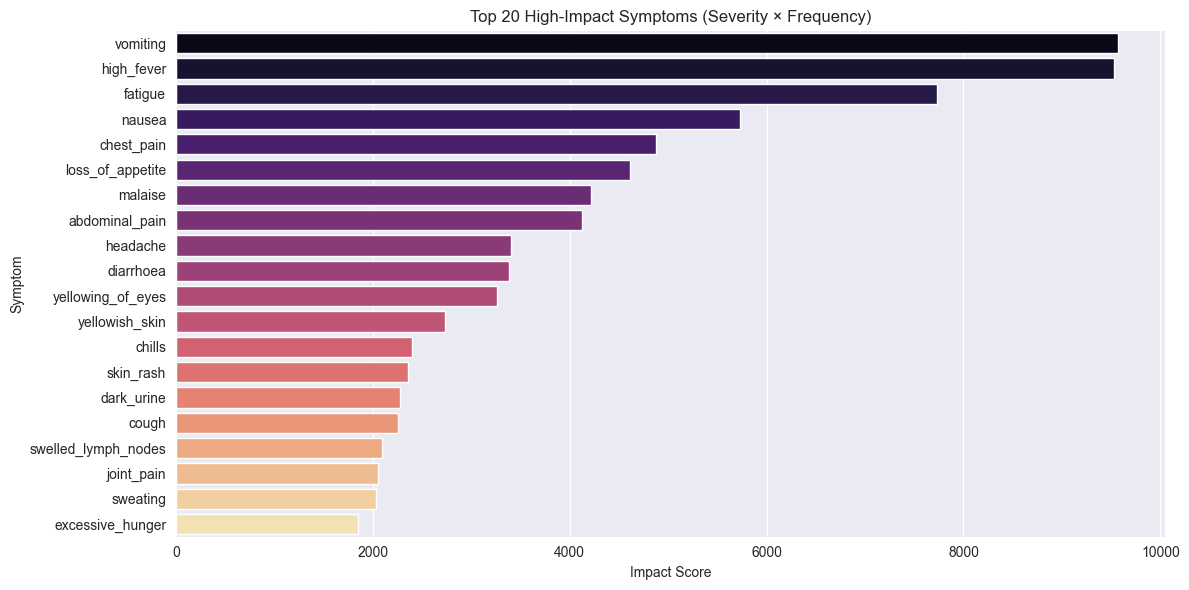

Patient Symptom Summary
------------------------
Predicted Disease: Heart attack

Extracted Symptoms:

Recommended Precautions:
 - call ambulance
 - chew or swallow asprin
 - keep calm
 - nan


In [106]:
## Named Entity Recognition (NER) with symptom_description.csv
import spacy
from spacy.matcher import PhraseMatcher

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Build matcher from symptom descriptions
symptom_list = desc_df['clean_text'].unique().tolist()
patterns = [nlp.make_doc(text) for text in symptom_list]
matcher = PhraseMatcher(nlp.vocab)
matcher.add("SYMPTOM", patterns)


def extract_entities(text):
    doc = nlp(clean_text(text))
    matches = matcher(doc)
    entities = [doc[start:end].text for match_id, start, end in matches]
    return entities


# Test NER function
sample_text = "I've been experiencing chest pain and shortness of breath with fatigue."
print("Extracted Entities:", extract_entities(sample_text))

## Most Severe Symptoms by Frequency
# Join with symptom severity
severity_df = pd.read_csv('../data/symptom-severity.csv')
severity_df.columns = [col.strip().lower() for col in severity_df.columns]

# Count symptom frequency
freq_map = Counter(all_symptoms)
severity_df['Frequency'] = severity_df['symptom'].map(freq_map)
severity_df = severity_df.dropna()

# Calculate severity x frequency score
severity_df['Impact'] = severity_df['weight'] * severity_df['Frequency']

# Plot top 20
top_impact = severity_df.sort_values(by='Impact', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_impact, x='Impact', y='symptom', palette='magma')
plt.title("Top 20 High-Impact Symptoms (Severity × Frequency)")
plt.xlabel("Impact Score")
plt.ylabel("Symptom")
plt.tight_layout()
plt.show()


## Generate Summary Report for Notion
def generate_summary(input_text):
    clean_input = clean_text(input_text)
    input_vec = vectorizer.transform([clean_input])
    prediction = model.predict(input_vec)[0]
    precautions = get_precautions(prediction)
    entities = extract_entities(input_text)

    print("Patient Symptom Summary")
    print("------------------------")
    print(f"Predicted Disease: {prediction}")
    print("\nExtracted Symptoms:")
    for ent in entities:
        print(f" - {ent}")
    print("\nRecommended Precautions:")
    for p in precautions:
        print(f" - {p}")


# Example
generate_summary("My mother is feeling weak, vomiting, and has yellowing of the skin.")


In [107]:
def generate_markdown_summary(input_text):
    clean_input = clean_text(input_text)
    input_vec = vectorizer.transform([clean_input])
    prediction = model.predict(input_vec)[0]
    precautions = get_precautions(prediction)
    entities = extract_entities(input_text)

    md = f"# Patient Symptom Summary\n\n"
    md += f"**Input Symptoms:** {input_text}\n\n"
    md += f"**Predicted Disease:** {prediction}\n\n"
    md += f"**Extracted Symptoms:**\n"
    for ent in entities:
        md += f"- {ent}\n"
    md += f"\n**Recommended Precautions:**\n"
    for p in precautions:
        md += f"- {p}\n"

    # Export to markdown file
    with open("outputs/patient_summary.md", "w") as f:
        f.write(md)

    print("✅ Markdown summary saved to: outputs/patient_summary.md")

In [108]:
import joblib

# Save the model and vectorizer
joblib.dump(model, '../models/disease_model.joblib')
joblib.dump(vectorizer, '../models/vectorizer.joblib')

['outputs/models/vectorizer.joblib']

In [109]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [110]:
import os
print("Model exists:", os.path.exists("../models/disease_model.joblib"))
print("Vectorizer exists:", os.path.exists("../models/vectorizer.joblib"))

Model exists: True
Vectorizer exists: True


# Fine-Tuning Script

In [112]:
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder

# Prepare dataset
df = pd.read_csv("../data/dataset.csv")
df = df.dropna()
df['symptoms'] = df[[col for col in df.columns if 'Symptom_' in col]].fillna('').apply(lambda row: ' '.join(row), axis=1)

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Disease'])

dataset = Dataset.from_pandas(df[['symptoms', 'label']])
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["symptoms"], truncation=True, padding=True)

encoded = dataset.map(tokenize, batched=True)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))

training_args = TrainingArguments(
    output_dir="./model_output",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    save_steps=10_000,
    logging_dir='./logs',
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded,
    eval_dataset=encoded
)

trainer.train()
model.save_pretrained("notebooks/outputs/transformer_model")
tokenizer.save_pretrained("notebooks/outputs/transformer_model")

Map: 100%|██████████| 72/72 [00:00<00:00, 12166.71 examples/s]


ImportError: 
DistilBertForSequenceClassification requires the PyTorch library but it was not found in your environment. Check out the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.
